**Reference** : 
1. http://nlp.seas.harvard.edu/2018/04/03/attention.html
2. https://github.com/lynnna-xu/text-generation-transformer 

# 0. Import/Installment

In [0]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [0]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#1. Define Transformer model

## Model Architecture -- Encoder-Decoder

In [0]:
class EncoderDecoder(nn.Module):

    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

class Generator_ffnn(nn.Module):
    '''
    This is the prediction layer
    '''

    def __init__(self, d_model, vocab):
        super(Generator_ffnn, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

## Encoder and Decoder Layers

In [0]:
def clone_layer(module, N):
    '''
    Clone N identical layers, which are then used in Encoder and Decoder
    '''
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

class normalization(nn.Module):
    '''
    This is for layer normalization
    '''
    def __init__(self, features, tol=1e-6):
        super(normalization, self).__init__()
        self.ones = nn.Parameter(torch.ones(features))
        self.zeros = nn.Parameter(torch.zeros(features))
        self.tol = tol

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.ones * (x - mean) / (std + self.tol) + self.zeros
    
class Skip_connection(nn.Module):
    """
    Skip connection to make sure enough useful information from input can be
    passed into a deeper layer
    """
    def __init__(self, size, dropout):
        super(Skip_connection, self).__init__()
        self.norm = normalization(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

class Encoder(nn.Module):

    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clone_layer(layer, N)
        self.norm = normalization(layer.size)
        
    def forward(self, x, mask):

        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)    
    

class EncoderLayer(nn.Module):
    '''
    Encoder layer is attention layer and feed forward network with skip connection
    '''
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clone_layer(Skip_connection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):

        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

class Decoder(nn.Module):

    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clone_layer(layer, N)
        self.norm = normalization(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

class DecoderLayer(nn.Module):
    '''
    Similar architecture as encoder layer, but add source attention layer
    '''
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clone_layer(Skip_connection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):

        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

def subsequent_mask(size):

    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

def attention(query, key, value, mask=None, dropout=None):
    '''
    Implement attention mechanisms
    '''
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0

        self.d_k = d_model // h
        self.h = h
        self.linears = clone_layer(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # Conduct linear projections
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        #apply attention
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        #Concat results
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)


## Position-wise Feed-Forward Networks

In [0]:
class PositionwiseFeedForward(nn.Module):

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## Embeddings Layer

In [0]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

## Positional Encoding

In [0]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        
        
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

#2. Build Full Model

In [0]:
def build_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=4, dropout=0.1):
    
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator_ffnn(d_model, tgt_vocab))

    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

#3. Data Loading

In [0]:
!pip install pytorch_pretrained_bert

     |████████████████████████████████| 133kB 2.8MB/s 


In [0]:
!gdown https://drive.google.com/uc?id=1OYcrdW8VdQrNQ-P0d8UotHx5QmY7TQaY
!unzip "/content/previous material.zip"

Downloading...
From: https://drive.google.com/uc?id=1OYcrdW8VdQrNQ-P0d8UotHx5QmY7TQaY
To: /content/previous material.zip
73.1MB [00:01, 68.6MB/s]
Archive:  /content/previous material.zip
   creating: data/
 extracting: Taylor_lyrics.ipynb     
 extracting: data/songdata.csv       
 extracting: data/tweet_sample.csv   
 extracting: data/Taylor_lyrics.ipynb  
 extracting: data/taylor_swift_lyrics.csv  
 extracting: data/processed_pop_sample.csv  
 extracting: data/taylor_swift_lyrics_sample.csv  


In [0]:
!cp data/taylor_swift_lyrics.csv  /content/

In [0]:
df = pd.read_csv('taylor_swift_lyrics.csv', encoding = "latin1")

In [0]:
df.head()

,artist,album,track_title,track_n,lyric,line,year
0,Taylor Swift,Taylor Swift,Tim McGraw,1,He said the way my blue eyes shined,1,2006
1,Taylor Swift,Taylor Swift,Tim McGraw,1,Put those Georgia stars to shame that night,2,2006
2,Taylor Swift,Taylor Swift,Tim McGraw,1,"I said, ""That's a lie""",3,2006
3,Taylor Swift,Taylor Swift,Tim McGraw,1,Just a boy in a Chevy truck,4,2006
4,Taylor Swift,Taylor Swift,Tim McGraw,1,That had a tendency of gettin' stuck,5,2006


In [0]:
df['lyrics'] = df['lyric'].str.replace('[^a-zA-Z]', ' ')
df[['trg', 'src']] = df['lyrics'].str.rsplit(n=1, expand=True)

In [0]:
df = df.drop(columns=['lyrics', 'lyric'])

In [0]:
df.to_csv('modified_taylor.csv')

In [0]:
df.columns

Index(['artist', 'album', 'track_title', 'track_n', 'line', 'year', 'trg',
       'src'],
      dtype='object')

## Split train, val, and test set

In [0]:
!head -n 800 modified_taylor.csv > test.csv
!tail -n +801 modified_taylor.csv > temp.csv

In [0]:
!head -n 200 temp.csv > val.csv
!tail -n +201 temp.csv > train.csv

In [0]:
# For data loading.
from torchtext import data, datasets
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
if True:
    # Load pre-trained model tokenizer (vocabulary)
    bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    def tokenize_bert(text):
        return bert_tokenizer.tokenize(text)
    BOS_WORD = '<s>'
    EOS_WORD = '</s>'
    BLANK_WORD = "<blank>"
    SRC = data.Field(tokenize=tokenize_bert, pad_token=BLANK_WORD)
    TGT = data.Field(tokenize=tokenize_bert, init_token = BOS_WORD, 
                     eos_token = EOS_WORD, pad_token=BLANK_WORD)    
    MAX_LEN = 150
    train, val, test = data.TabularDataset.splits(
        path='/content/', format='csv', train='train.csv',
        validation='val.csv', test='test.csv',
        fields=[('', None), ('artist', None), ('album', None), ('track_title', None), ('track_n', None), ('line', None), ('year', None), ('trg', TGT), ('src', SRC)], skip_header=True)    
    MIN_FREQ = 2
    SRC.build_vocab(train.src, min_freq=MIN_FREQ)
    TGT.build_vocab(train.trg, min_freq=MIN_FREQ)

100%|██████████| 231508/231508 [00:00<00:00, 319283.20B/s]


### Iterator

In [0]:
class BatchIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        # print(b.size())
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

def rebatch(pad_idx, batch):
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    src = src.cuda()
    trg = trg.cuda()
    return Batch(src, trg, pad_idx)

#4. Setup Training

In [0]:
class Batch:
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask
    
def run_epoch(data_iter, model, loss_compute, opt):

    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        opt.optimizer.zero_grad()
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        temp_out = model.generator(out)
        loss = loss_compute(temp_out.view(-1, temp_out.size(-1)), batch.trg_y.contiguous().view(-1))
        total_loss += loss.item()
        total_tokens += batch.ntokens
        loss.backward()
        opt.step()
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return model, total_loss / total_tokens

global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9))

class LabelSmoothing(nn.Module):
    '''
    Implement label smoothing according from the reference
    '''
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        # print("in loss: ", x.size(), target.size())
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))
    
def text_gen(model, src, src_mask, max_len, start_symbol):
    '''
    Generate text
    '''

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

In [0]:
# GPUs to use
devices = [0]
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if True:
    pad_idx = TGT.vocab.stoi["<blank>"]
    model = build_model(len(SRC.vocab), len(TGT.vocab), N=6)
    model = model.cuda()
    criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
    criterion = criterion.cuda()
    BATCH_SIZE = 512
    train_iter = BatchIterator(train, batch_size=BATCH_SIZE, device=0,
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=True)
    valid_iter = BatchIterator(val, batch_size=BATCH_SIZE, device=0,
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=False)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


In [0]:
len(TGT.vocab)

1064

### Training the System

In [0]:
if True:
    model_opt = NoamOpt(model.src_embed[0].d_model, 1, 2000,
            torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.98), eps=1e-9))
    # opt = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.98), eps=1e-9)
    for epoch in range(10):
        print(epoch)
        model.train()
        model, _ = run_epoch((rebatch(pad_idx, b) for b in train_iter), 
                  model, 
                  criterion, model_opt)      

#### Save:

In [0]:
PATH = '/content/drive/My Drive/lc_60epoch_6layers.pt'
torch.save(model.state_dict(), PATH)

#### Load:

In [0]:
!gdown https://drive.google.com/uc?id=1-BenYw-mCDbh0kMd7tGNjoGi8m9SGBT-
!gdown https://drive.google.com/uc?id=1MRWb4yDDWPBJvJS3w2NqPitBXzPsOQTd

Downloading...
From: https://drive.google.com/uc?id=1-BenYw-mCDbh0kMd7tGNjoGi8m9SGBT-
To: /content/lc_60epoch_6layers.pt
202MB [00:04, 50.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1MRWb4yDDWPBJvJS3w2NqPitBXzPsOQTd
To: /content/lyricsText.txt
100% 174k/174k [00:00<00:00, 61.1MB/s]


In [0]:
PATH= '/content/lc_60epoch_6layers.pt'
model = build_model(len(SRC.vocab), len(TGT.vocab), N=6)
model = model.cuda()
model.load_state_dict(torch.load(PATH))
model.eval()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): Skip_connection(
            (norm): normalization()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): Skip_connection(
            (norm): normalization

#### one example prediction

In [0]:
# ## predict online

# name_lis = ['She said the way her black eye', 
#            'Just a boy in my hand',
#            "I don't know",
#            'You are my love']
def predict_online(s):
    ans = []
    product_name = s
    example = data.Example.fromlist([product_name, ''], 
                                fields=[('src', SRC), ('trg', TGT)])
    src = torch.LongTensor([list(SRC.vocab.stoi[s] for s in example.src)])
    print('*'*110)
    print(src)
    src = src.cuda()
    src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2)
    src_mask = src_mask.cuda()
    out = text_gen(model, src, src_mask, 
                        max_len=100, start_symbol=TGT.vocab.stoi["<s>"])    
    print("Source:", end="\t")
    print(product_name)
    print("Generated:", end="\t")
    for i in range(1, out.size(1)):
        sym = TGT.vocab.itos[out[0, i]]
        if sym == "</s>": break
        if sym != "<unk>": 
          print(sym, end =" ") 
          ans.append(sym)
    print()
    return ans
# for _ in name_lis:
#     predict_online(_)

#5. Final prediction

In [0]:
with open('lyricsText.txt', 'r+') as f:
  original = []
  final = []
  k = 0
  for i in f:
    if k < 20:
      original.append(i[:-2])
      ans = predict_online(i)
      seen = {}
      for j in ans:
        if j not in seen:
          seen[j] =1
        else:
          seen[j] +=1
      indicator = 0
      for key, val in seen.items():
        if val >=10:
          indicator=1
      if indicator ==0:
        final.append(' '.join(ans))
    k +=1


**************************************************************************************************************
tensor([[401, 101,   0,  68,   0, 368, 121, 137,   0]])
Source:	He said the way my blue eyes shined

Generated:	and i hope sometimes you wonder about your 
**************************************************************************************************************
tensor([[ 0,  0,  0,  0, 43,  0, 17, 61]])
Source:	Put those Georgia stars to shame that night

Generated:	and i hope you don t save you got 
**************************************************************************************************************
tensor([[ 18, 101,   0,   0,  17,   0,   0,   0,   0,   0]])
Source:	I said, "That's a lie"

Generated:	and i hope sometimes you wonder about 
**************************************************************************************************************
tensor([[  0,   0, 271,  21,   0,   0,   0]])
Source:	Just a boy in a Chevy truck

Generated:	but you can take me d

In [0]:
original

['He said the way my blue eyes shine',
 'Put those Georgia stars to shame that nigh',
 'I said, "That\'s a lie',
 'Just a boy in a Chevy truc',
 "That had a tendency of gettin' stuc",
 'On backroads at nigh',
 'And I was right there beside him all summer lon',
 'And then the time we woke up to find that summer gon',
 'But when you think Tim McGra',
 'I hope you think my favorite son',
 'The one we danced to all night lon',
 'The moon like a spotlight on the lak',
 'When you think happines',
 'I hope you think that little black dres',
 'Think of my head on your ches',
 'And my old faded blue jean',
 'When you think Tim McGra',
 'I hope you think of m',
 'September saw a month of tear',
 "And thankin' God that you weren't her"]

In [0]:
final

['and i hope sometimes you wonder about your',
 'and i hope you don t save you got',
 'and i hope sometimes you wonder about',
 'but you can take me down with just one single',
 'i i i loved you in',
 'bar on the side where you',
 'i m wine in the',
 'you don t know how nice that is but i m',
 'we were jet set and and the',
 'but you weren t',
 'and i love you because you have me no choice but',
 'and i got that red lip classic thing that you',
 'but you weren t',
 'and i hope you don t save you know',
 'you re not a saint and she s not what you',
 'oh how were you to know',
 'but you weren t',
 'but you weren t',
 'we re all here the lights and noise are',
 'you said you d be']

# 6. Evaluation/Evaluation Metrics

### World Cloud

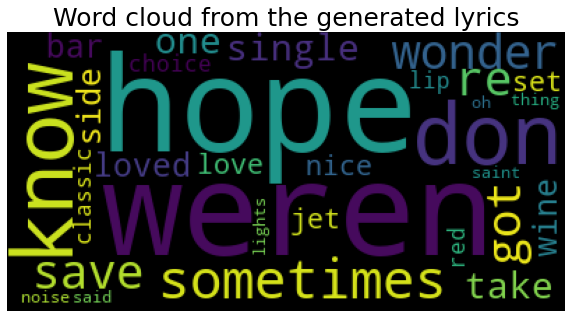

In [0]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# combine all the generated lyrics into a string, and feed it into the wordcloud generate function
wc = WordCloud().generate(','.join(l for l in final))

# form the word cloud of the most frequently used words in the lyrics
plt.figure(figsize=(10,30))
plt.title('Word cloud from the generated lyrics', fontsize=25)
plt.imshow(wc)
plt.axis("off") # added to not display the x and y axis
plt.show()

### ​Flow Irregularity
Not Rhyme Density (RD)??
- Now our aim is to give a score to list of the last 2 unique charactes list we formed earlier. This is done in order to give closer score to the words which end with the same syllable sound.

- To calculate the value for the index position, we are using the formula:
                [Index position of the 2 charcaters in the list] / [Total length of the list]


In [0]:
!pip install pronouncing
!pip install pywsd
!pip install syllables

     |████████████████████████████████| 942kB 3.8MB/s 
  Created wheel for pronouncing: filename=pronouncing-0.2.0-py2.py3-none-any.whl size=6223 sha256=cb8ad5ae3e724912b7adf85d62610939555716004afcb9cc649892cd99710e3d
  Stored in directory: /root/.cache/pip/wheels/81/fd/e8/fb1a226f707c7e20dbed4c43f81b819d279ffd3b0e2f06ee13
Successfully built pronouncing
     |████████████████████████████████| 26.8MB 117kB/s 
     |████████████████████████████████| 31.6MB 201kB/s 
  Created wheel for pywsd: filename=pywsd-1.2.4-cp36-none-any.whl size=26940453 sha256=4c829bd86d72241695b5aa12c8c3a4b4ab872f2b95e892026b94ab6846c60109
  Stored in directory: /root/.cache/pip/wheels/71/4d/d2/405b948047f7f3851f16ab9d893ce7c1a3010182900884536b
  Created wheel for wn: filename=wn-0.0.23-cp36-none-any.whl size=31792943 sha256=0d7e32f7e3352e21c4289477c652b5f8eecd4d1821b521f326c1baf71afc469e
  Stored in directory: /root/.cache/pip/wheels/56/e3/c4/886021dbf4d758dc3cb9ddaa47d7d6fc895240d83f010e6305
Successfully built 

In [0]:
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from pywsd.utils import lemmatize_sentence
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
import pronouncing

nltk.download('punkt')
import nltk 
nltk.download('wordnet') 

stemmer = nltk.stem.porter.PorterStemmer()
lmm = WordNetLemmatizer()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
import re
def rhyming_list_all(bars):
    rhyme_list_all = []
    rhyming_list_final = []
    for bar in bars:
        # taking the last word in each bar
        last_word = re.sub(r"\W+", '', bar.split(" ")[-1]).lower()
        # finding the rhyming word for 'last_word'
        rhyming_words = pronouncing.rhymes(last_word)
        rhyming_words_ending = []
        for rhyming_word in rhyming_words:
            rhyming_words_ending.append(rhyming_word[-2:]) # this will pull the last 2 characters from each rhyming word
        # now we see that which of the 2 characters in the rhyming_words_ending list occur the most
        # we used a try except to capture rythme character, if rhyme character is not found, we take the last 2 characters of the original word
        try:
            rhyming_words_ending_most_common = max(set(rhyming_words_ending), key = rhyming_words_ending.count)
        except Exception:
            rhyming_words_ending_most_common = last_word[-2:]
        rhyme_list_all.append(rhyming_words_ending_most_common)
    # now take the set of rythme to obtain unique last 2 characters
    rhyme_list_all = list(set(rhyme_list_all))
    reverse_list = [x[::-1] for x in rhyme_list_all] #  use slicing syntax to reverse the letters[start,stop,step],
    reverse_list = sorted(reverse_list) # sort the characters
    # now we reverse the string again, so that words with similar sounds can be taken in order
    rhyming_list_final =  [x[::-1] for x in reverse_list]
    return rhyming_list_final

In [0]:
rhyming_list_final = rhyming_list_all(final) # contain the list of all common rhyming words (last 2 characters) used in the lyrics across all bars
rhyming_list_final

['ee', 'he', 'le', 're', 'em', 'in', 'ar', 'tt', 'ut', 'au', 'ew']

In [0]:
# we are doing the following steps to see that how close the rhyming words are each other
# This will make the last words which are similar in rhyme to get closer scores

def index_rhyming_word_to_float(rhyming_list_final, bar):
    word = re.sub(r"\W+", '', bar.split(" ")[-1]).lower()
    rhymeslist = pronouncing.rhymes(word)
    rhymeslistends = []
    for i in rhymeslist:
        rhymeslistends.append(i[-2:])
    try:
        rhymescheme = max(set(rhymeslistends), key=rhymeslistends.count)
    except Exception:
        rhymescheme = word[-2:]
    try:
        float_rhyme = rhyming_list_final.index(rhymescheme)
        float_rhyme = float_rhyme / float(len(rhyming_list_final))
        float_rhyme = round(float_rhyme,3)
        return float_rhyme
    except Exception:
        return 0

### Internal Density (ID)
- We are considering the maximun number of syllables for out rap song to be the average number of syllables across each bar in bars
                     Average syllables = [sum of syllables across each bar] / [total number of bar] 

In [0]:
import syllables
syllable_list_bar = []
def find_syllables_count(bar):
    syllable_list_bar.append(syllables.estimate(bar))
    estimate = syllables.estimate(bar)/12 # average syllables count in a bar
    estimate = round(estimate,3)
    return estimate

In [0]:
final_values = []
for bar in final:
    data_with_value = [bar, find_syllables_count(bar), index_rhyming_word_to_float(rhyming_list_final, bar)]
    final_values.append(data_with_value)
final_values

[['and i hope sometimes you wonder about your', 1.167, 0.273],
 ['and i hope you don t save you got', 0.833, 0.636],
 ['and i hope sometimes you wonder about', 1.083, 0.727],
 ['but you can take me down with just one single', 1.083, 0.182],
 ['i i i loved you in', 0.583, 0.455],
 ['bar on the side where you', 0.667, 0.909],
 ['i m wine in the', 0.417, 0.091],
 ['you don t know how nice that is but i m', 0.833, 0.364],
 ['we were jet set and and the', 0.667, 0.091],
 ['but you weren t', 0.333, 0.0],
 ['and i love you because you have me no choice but', 1.333, 0.727],
 ['and i got that red lip classic thing that you', 0.917, 0.909],
 ['but you weren t', 0.333, 0.0],
 ['and i hope you don t save you know', 0.833, 0.818],
 ['you re not a saint and she s not what you', 0.833, 0.909],
 ['oh how were you to know', 0.583, 0.818],
 ['but you weren t', 0.333, 0.0],
 ['but you weren t', 0.333, 0.0],
 ['we re all here the lights and noise are', 1.0, 0.545],
 ['you said you d be', 0.333, 0.0]]

### Jaccard Similarity

The Jaccard similarity index (sometimes called the Jaccard similarity coefficient) compares members for two sets to see which members are shared and which are distinct. 

It’s a measure of similarity for the two sets of data, with a range from 0% to 100%. The higher the percentage, the more similar the two populations. 

In [0]:
def get_jaccard_sim(text1, text2): 
    a = set(text1.split()) 
    b = set(text2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [0]:
print('Jaccard similarity is: ', get_jaccard_sim(' '.join(original), ' '.join(final)))

Jaccard similarity is:  0.09859154929577464


### Cosine similarity

Cosine similarity calculates similarity by measuring the cosine of angle between two vectors. With cosine similarity, we need to convert sentences into vectors. One way to do that is to use bag of words with either TF (term frequency) or TF-IDF (term frequency- inverse document frequency).

TF is good for text similarity in general, but TF-IDF is good for search query relevance.

In [0]:
stemmer = nltk.stem.porter.PorterStemmer()
lmm = WordNetLemmatizer()

word_list1 = nltk.word_tokenize(' '.join(original))
lemmatized_output1 = ' '.join([lmm.lemmatize(w) for w in word_list1])
word_list2 = nltk.word_tokenize(' '.join(final))
lemmatized_output2 = ' '.join([lmm.lemmatize(w) for w in word_list2])

In [0]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer(stop_words='english')
def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]
print(cosine_sim(lemmatized_output1, lemmatized_output2))

tf = vectorizer.fit_transform([lemmatized_output1, lemmatized_output2])
similarity_matrix = cosine_similarity(tf)
print(similarity_matrix)

0.07396593354428418
[[1.         0.07396593]
 [0.07396593 1.        ]]


### BLEU Score

The Bilingual Evaluation Understudy Score, or BLEU for short, is a metric for evaluating a generated sentence to a reference sentence.

A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.

In [0]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import corpus_bleu
b = ' '.join(original).split(' ')
a = ' '.join(final).split(' ')
score = sentence_bleu(a, b)
print(score)

0.3463409141017178


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
